## Figure S9: Visualize Fitted Model

This code creates Figure S9 in the supplement.

In [7]:
import numpy as np
import pickle
import seaborn as sns
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as sio
import pystan #Python interface for Stan (Stan implements Hamiltonian Monte Carlo)

In [8]:
#Print working directory and change it if needed. All data files should be in your working directory.
#import os
#print(os.getcwd())
#os.chdir('...enter the address to your directory here...')

#Load the experimental data 
data12cls = np.load('ExperimentalData.npy')
# data12cls has 12 columns. The first 4 columns are the time course data for the OD and the 
# fluorescence signals of strains X, Y, and Z for the first experiment (rX=0.4667, rY=0.2). The second
# 4 columns are the timecourse data for the second experiment (rX=0.2, rY=0.4667) and the last 4 columns 
# are those for the third experiment (rX=0.2, rY=0.2).

#Load the fitting (inference) data from a saved pickle file
with open("fitResults1.pkl", "rb") as f:
    data_dict = pickle.load(f)
    
stanModel  = data_dict['model']
fitData = data_dict['fit']  

In [9]:
# Get the MAP (Maximum A Posteriori) estimate
trace = fitData.extract() #trace is a dictionary that contains samples and log of the posterior distribution
trace.keys()
index_MAP = np.argmax(trace['lp__']) #Finds the index of the parameters with maximum log posterior
MAP_pars = trace['theta'][index_MAP,:]

In [10]:
#Define the ODE model of the IFFL dynamics
def iffl(y, t, *pars):   
    #parameters   
    rX, rY, ts, K_t, n, t_induc, lam_s, C_t, alpha_t1_s, \
    alpha_t2_s, alpha_t3_s, D_t1_s, D_t2_s, D_t3_s, alpha_s1_tt, alpha_s2_tt = pars
    
    rZ=1-rX-rY
    
    dy = np.zeros(6)
    # total cell population
    dy[0] = 0.01*lam_s*y[0]*(1-y[0]/C_t) 
    
    #regulation terms
    Hill_XtoY = y[4]**n/(1+y[4]**n)
    Hill_XtoZ = Hill_XtoY
    Hill_YtoZ = 1.0/(1+y[5]**n)
    
    #protein fluorescence values
    dy[1] = 100*alpha_t1_s*rX*y[0]*((t>t_induc) & (t<t_s))-100*D_t1_s*rX*y[0]*y[1]/(K_t*rX*y[0]+y[1])
    dy[2] = 100*alpha_t2_s*rY*y[0]*Hill_XtoY*((t>t_induc) & (t<t_s))-100*D_t2_s*rY*y[0]*y[2]/(K_t*rY*y[0]+y[2])
    dy[3] = 100*alpha_t3_s*rZ*y[0]*Hill_XtoZ*Hill_YtoZ*((t>t_induc) & (t<t_s))-100*D_t3_s*rZ*y[0]*y[3]/(K_t*rZ*y[0]+y[3])
    
    #HSL concentrations
    dy[4]    = 10**-alpha_s1_tt * y[1]
    dy[5]    = 10**-alpha_s2_tt * y[2]

    return dy

In [11]:
# Set fixed parameters of the model
N_t_0      = 0.008577 #initial OD
t_s        = 270.0 #minutes
K_t        = 3.6e4
n          = 2
t_induc    = 120.0 #minutes

#Load strain fractions measured by next-gen sequencing results
#measured_fracs = sio.loadmat('measured_fracs_time0.mat')
#First experiment: r_Z=0.33 (3rd condition)
#exper = 0 #fixZ
#day=0 #day 1 of the fixZ experiment
#cond=2 #3rd condition corresponding to target fractions (rX=0.4667, rY=0.2)
#rX_1 = measured_fracs['measured_fracs_time0'][0, cond, day, exper]   #strain X
#rY_1 = measured_fracs['measured_fracs_time0'][1, cond, day, exper]   #strain Y
#After loading we get:
rX_1 = 0.3104  
rY_1 = 0.2459 

#Second experiment: r_Z=0.33 (7th condition)
#cond=6 #7th condition corresponding to target fractions (rX=0.2, rY=0.4667)
#rX_2 = measured_fracs['measured_fracs_time0'][0, cond, day, exper]   #strain X
#rY_2 = measured_fracs['measured_fracs_time0'][1, cond, day, exper]   #strain Y
rX_2 = 0.1002 
rY_2 = 0.5378 

#Third experiment: Experiment with r_X=0.2 (5th condition)
#exper = 1 #fixX
#day=1 #day 2 of the fixX experiment
#cond=4 #5th condition corresponding to target fractions (rX=0.2, rY=0.2)
#rX_3 = measured_fracs['measured_fracs_time0'][0, cond, day, exper]   #strain X
#rY_3 = measured_fracs['measured_fracs_time0'][1, cond, day, exper]   #strain Y
rX_3 = 0.1486 
rY_3 = 0.1683 

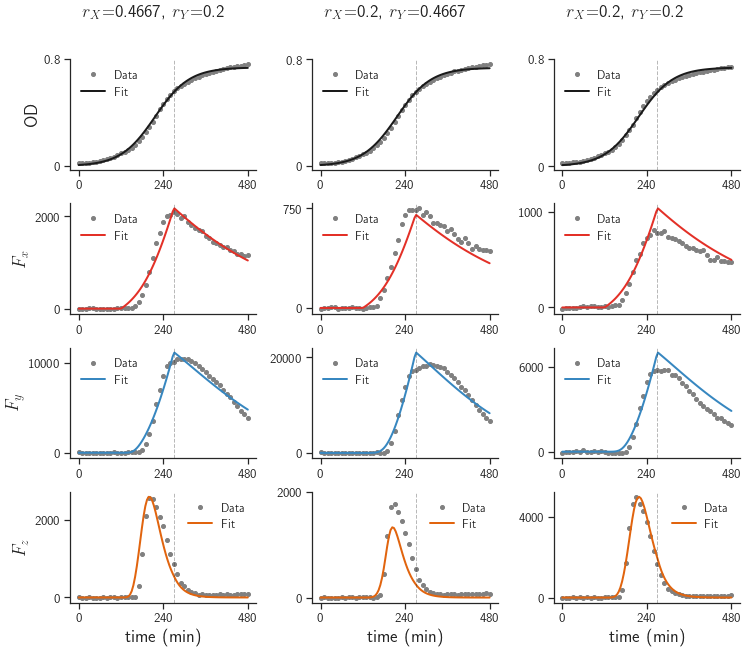

In [12]:
#Plot the data and the MAP fit
sns.set()
sns.set(font_scale=1.2)
sns.set_style('ticks')
red_colors = sns.color_palette("Reds_d",9)
blue_colors = sns.color_palette("Blues_d",9)
orange_colors = sns.color_palette("YlOrBr_d",9)

y_init = np.append(N_t_0,np.zeros(5))
num_tps=len(data12cls[:,0])
t_plot=np.linspace(0,(num_tps-1)*10,100)
tps=np.array(range(0,num_tps*10,10))
fixed_pars = (t_s,K_t,n,t_induc)



fig_fit = plt.figure(figsize=(12,10))
simulation_pars = (rX_1, rY_1, *fixed_pars, *MAP_pars)
MAP_sol = odeint(iffl, y_init, t_plot, args=simulation_pars)
plt.subplot(4,3,1)    
plt.plot(tps, data12cls[:,0], marker=".", color='gray', linestyle="None", markersize=8, label='Data')
plt.plot(t_plot, MAP_sol[:, 0], lw=2, label='Fit', color='k') 
plt.axvline(t_s, linestyle='--', color='k', lw=1, alpha=0.3)
plt.text(10,1.1,'$r_X$=0.4667, $r_Y$=0.2', fontsize=18)  
plt.legend(fontsize=12, frameon=False)
plt.ylabel('OD', fontsize=18)
plt.xticks((0,240,480),(0,240,480))
plt.yticks((0,0.8),(0,0.8))
sns.despine()
plt.subplot(4,3,4)    
plt.plot(tps, data12cls[:,1], marker=".", color='gray', linestyle="None", markersize=8, label='Data')
plt.plot(t_plot, MAP_sol[:, 1], lw=2, color=red_colors[4], label='Fit') 
plt.legend(fontsize=12, frameon=False)
plt.axvline(t_s, linestyle='--', color='k', lw=1, alpha=0.3)
plt.ylabel('$F_x$', fontsize=18)
plt.xticks((0,240,480),(0,240,480))
sns.despine()
plt.yticks((0,2000),(0,2000))
plt.subplot(4,3,7)    
plt.plot(tps, data12cls[:,2], marker=".", color='gray', linestyle="None", markersize=8, label='Data')
plt.plot(t_plot, MAP_sol[:, 2], lw=2, color=blue_colors[4], label='Fit') 
plt.axvline(t_s, linestyle='--', color='k', lw=1, alpha=0.3)    
plt.legend(fontsize=12, frameon=False)
plt.ylabel('$F_y$', fontsize=18)
plt.xticks((0,240,480),(0,240,480))
sns.despine()
plt.yticks((0,10000),(0,10000))
plt.subplot(4,3,10)    
plt.plot(tps, data12cls[:,3], marker=".", color='gray', linestyle="None", markersize=8, label='Data')
plt.plot(t_plot, MAP_sol[:, 3], lw=2,  color=orange_colors[4], label='Fit') 
plt.axvline(t_s, linestyle='--', color='k', lw=1, alpha=0.3)
plt.legend(fontsize=12, frameon=False)
plt.xlabel('time (min)', fontsize=18)
plt.ylabel('$F_z$', fontsize=18)
plt.xticks((0,240,480),(0,240,480))
sns.despine()
plt.yticks((0,2000),(0,2000))



simulation_pars = (rX_2, rY_2, *fixed_pars, *MAP_pars)
MAP_sol = odeint(iffl, y_init, t_plot, args=simulation_pars)
plt.subplot(4,3,2)    
plt.plot(tps, data12cls[:,4], marker=".", color='gray', linestyle="None", markersize=8, label='Data')
plt.plot(t_plot, MAP_sol[:, 0], lw=2, label='Fit', color='k') 
plt.axvline(t_s, linestyle='--', color='k', lw=1, alpha=0.3)
plt.text(10,1.1,'$r_X$=0.2, $r_Y$=0.4667', fontsize=18)  
plt.legend(fontsize=12, frameon=False)
plt.xticks((0,240,480),(0,240,480))
plt.yticks((0,0.8),(0,0.8))
sns.despine()
plt.subplot(4,3,5)    
plt.plot(tps, data12cls[:,5], marker=".", color='gray', linestyle="None", markersize=8, label='Data')
plt.plot(t_plot, MAP_sol[:, 1], lw=2, color=red_colors[4], label='Fit') 
plt.legend(fontsize=12, frameon=False)
plt.axvline(t_s, linestyle='--', color='k', lw=1, alpha=0.3)
plt.xticks((0,240,480),(0,240,480))
sns.despine()
plt.yticks((0,750),(0,750))
plt.subplot(4,3,8)    
plt.plot(tps, data12cls[:,6], marker=".", color='gray', linestyle="None", markersize=8, label='Data')
plt.plot(t_plot, MAP_sol[:, 2], lw=2, color=blue_colors[4], label='Fit')  
plt.axvline(t_s, linestyle='--', color='k', lw=1, alpha=0.3)   
plt.legend(fontsize=12, frameon=False)
plt.xticks((0,240,480),(0,240,480))
sns.despine()
plt.yticks((0,20000),(0,20000))
plt.subplot(4,3,11)    
plt.plot(tps, data12cls[:,7], marker=".", color='gray', linestyle="None", markersize=8, label='Data')
plt.plot(t_plot, MAP_sol[:, 3], lw=2,  color=orange_colors[4], label='Fit') 
plt.axvline(t_s, linestyle='--', color='k', lw=1, alpha=0.3)
plt.legend(fontsize=12, frameon=False)
plt.xlabel('time (min)', fontsize=18)
plt.xticks((0,240,480),(0,240,480))
sns.despine()
plt.yticks((0,2000),(0,2000))



simulation_pars = (rX_3, rY_3, *fixed_pars, *MAP_pars)
MAP_sol = odeint(iffl, y_init, t_plot, args=simulation_pars)
plt.subplot(4,3,3)    
plt.plot(tps, data12cls[:,8], marker=".", color='gray', linestyle="None", markersize=8, label='Data')
plt.plot(t_plot, MAP_sol[:, 0], lw=2, label='Fit', color='k') 
plt.axvline(t_s, linestyle='--', color='k', lw=1, alpha=0.3)
plt.text(10,1.1,'$r_X$=0.2, $r_Y$=0.2', fontsize=18)  
plt.legend(fontsize=12, frameon=False)
plt.xticks((0,240,480),(0,240,480))
plt.yticks((0,0.8),(0,0.8))
sns.despine()
plt.subplot(4,3,6)    
plt.plot(tps, data12cls[:,9], marker=".", color='gray', linestyle="None", markersize=8, label='Data')
plt.plot(t_plot, MAP_sol[:, 1], lw=2, color=red_colors[4], label='Fit') 
plt.legend(fontsize=12, frameon=False)
plt.axvline(t_s, linestyle='--', color='k', lw=1, alpha=0.3)
plt.xticks((0,240,480),(0,240,480))
sns.despine()
plt.yticks((0,1000),(0,1000))
plt.subplot(4,3,9)    
plt.plot(tps, data12cls[:,10], marker=".", color='gray', linestyle="None", markersize=8, label='Data')
plt.plot(t_plot, MAP_sol[:, 2], lw=2, color=blue_colors[4], label='Fit')  
plt.axvline(t_s, linestyle='--', color='k', lw=1, alpha=0.3)   
plt.legend(fontsize=12, frameon=False)
plt.xticks((0,240,480),(0,240,480))
sns.despine()
plt.yticks((0,6000),(0,6000))
plt.subplot(4,3,12)    
plt.plot(tps, data12cls[:,11], marker=".", color='gray', linestyle="None", markersize=8, label='Data')
plt.plot(t_plot, MAP_sol[:, 3], lw=2,  color=orange_colors[4], label='Fit') 
plt.axvline(t_s, linestyle='--', color='k', lw=1, alpha=0.3)
plt.legend(fontsize=12, frameon=False)
plt.xlabel('time (min)', fontsize=18)
plt.xticks((0,240,480),(0,240,480))
sns.despine()
plt.yticks((0,4000),(0,4000))

#export figure
fig_fit.subplots_adjust(wspace=0.3, hspace=0.3)
fig_fit.savefig("FigS9_ModelFitting.pdf", bbox_inches='tight', transparent=True)